In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn import svm, cross_validation, grid_search, base
from sklearn.cross_validation import LeaveOneOut
import numpy as np
import pandas as pd
from scipy import interp, stats
import pylab as pl
from sklearn.metrics import roc_curve, auc, recall_score, matthews_corrcoef, make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFdr, f_classif, SelectPercentile, SelectKBest, RFECV, SelectFromModel
from sklearn.linear_model import RandomizedLogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.naive_bayes import BernoulliNB, GaussianNB
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import os
import math
from sklearn import preprocessing
from sklearn.covariance import EmpiricalCovariance
from sklearn.model_selection import GridSearchCV

/home/wjin/anaconda/envs/wjin/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/wjin/anaconda/envs/wjin/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
train_df=pd.read_table('./ads_train.csv',sep=',',index_col=0)
test_df=pd.read_table('./ads_test.csv',sep=',',index_col=0)
train_df.buy_freq=train_df.buy_freq.apply(lambda x: -1 if np.isnan(x) else x)
test_df.buy_freq=test_df.buy_freq.apply(lambda x: -1 if np.isnan(x) else x)
train_yes=train_df[train_df.y_buy==1]
train_no=train_df[train_df.y_buy==0]
X=np.array(train_df[train_df.columns[:-1]])
y=np.array(train_df[train_df.columns[-1]])
X_t=np.array(test_df)
X_all=np.concatenate((X,X_t))
X_all_norm=preprocessing.normalize(X_all)
X_norm=X_all[:X.shape[0],:]
X_norm_t=X_all[X.shape[0]:,:]

In [3]:
X_all=np.concatenate((X,X_t))
X_all.shape

(54584, 13)

## Summary

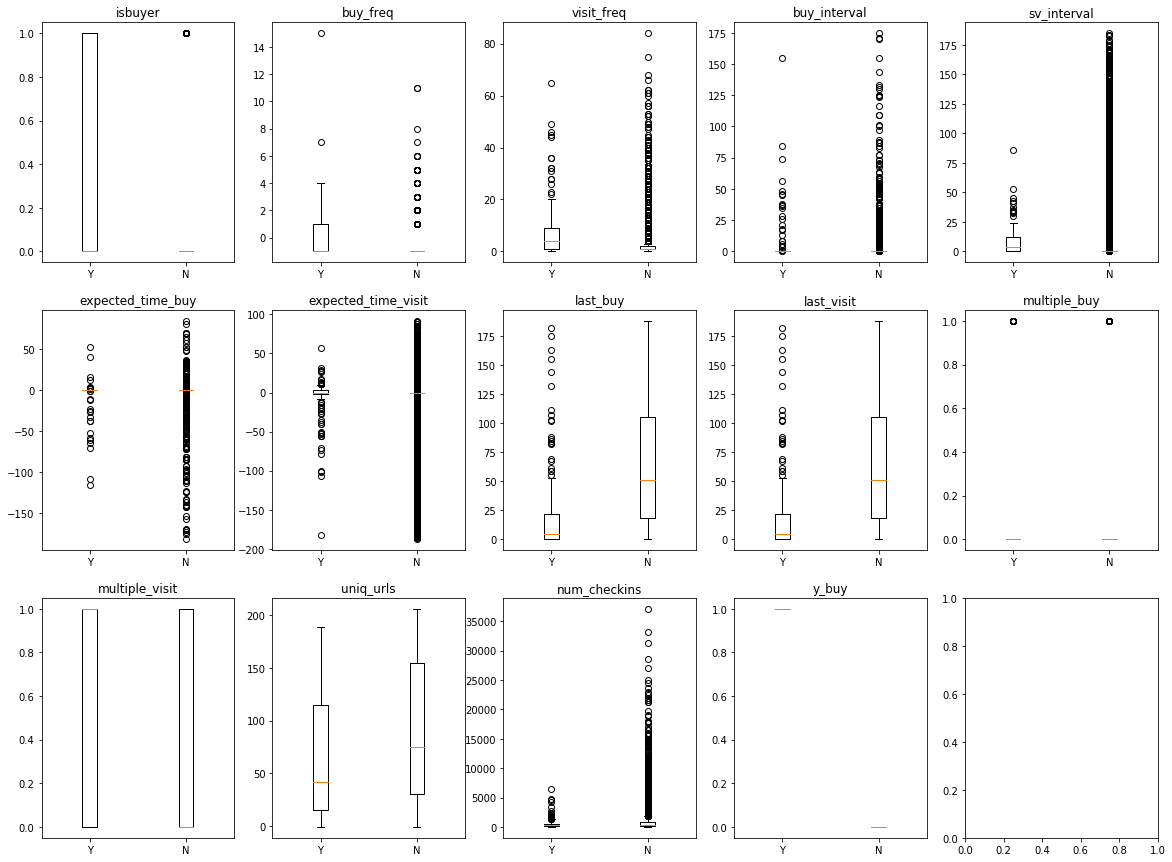

In [4]:
f,ax=plt.subplots(3,5,figsize=(20,15))
ax0=ax.flatten()
for ax1, column in zip(ax0, train_df.columns):
    ax1.boxplot([train_yes[column], train_no[column]])
    ax1.set_title(column)
    ax1.set_xticklabels(['Y','N'])

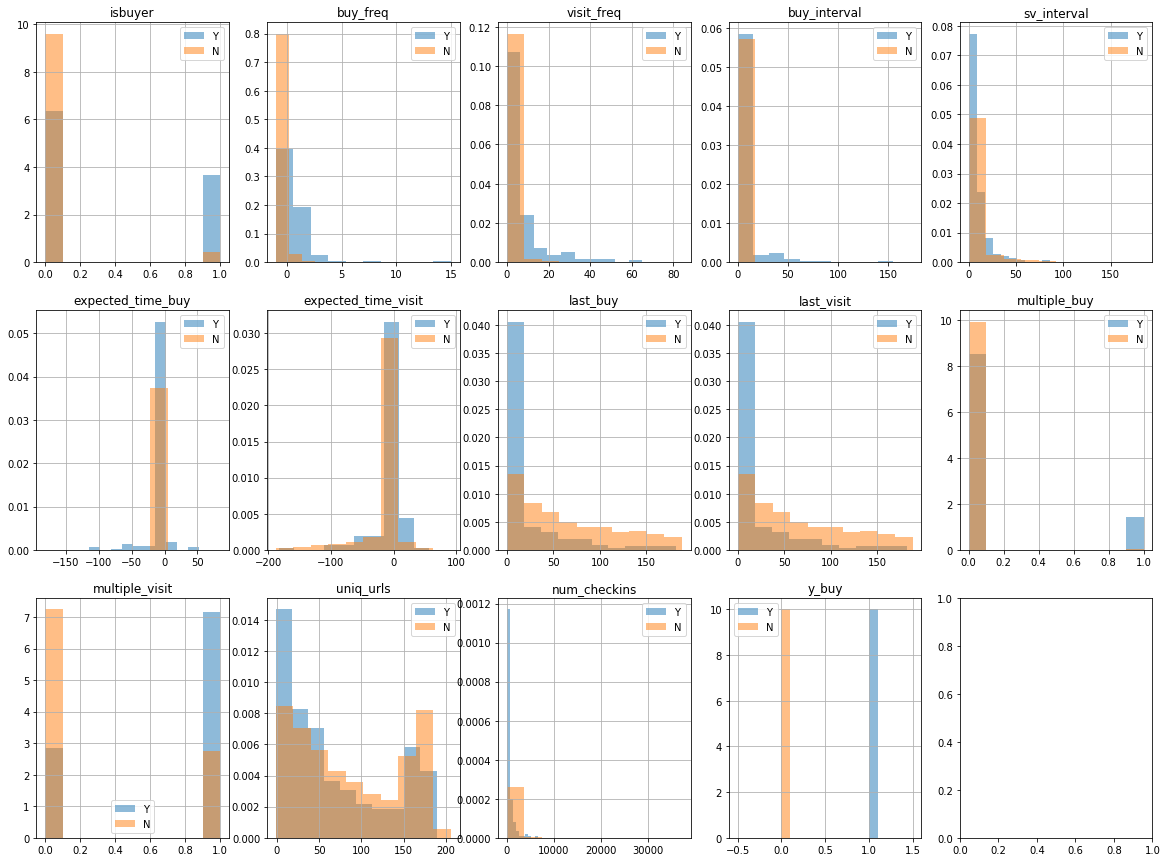

In [5]:
f,ax=plt.subplots(3,5,figsize=(20,15))
ax0=ax.flatten()
for ax1, column in zip(ax0, train_df.columns):
    train_yes[column].hist(ax=ax1,normed=True,alpha=0.5, label='Y')
    train_no[column].hist(ax=ax1,normed=True,alpha=0.5, label='N')
    ax1.set_title(column)
    ax1.legend()

Covariance

/home/wjin/anaconda/envs/wjin/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


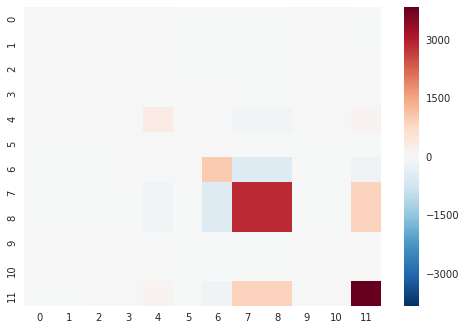

In [6]:
import seaborn as sns
cov=EmpiricalCovariance().fit(X[:-1,:-1])

sns.heatmap(cov.covariance_)

#### Build model with selected features

In [7]:
#clf_rf=RandomForestClassifier(class_weight='balanced')
#clf_svm=SVC(kernel='rbf',class_weight='balanced')
clf_lsvm=LinearSVC(penalty='l1',dual=False,class_weight='balanced')
clf_lr=LogisticRegression(class_weight='balanced')

In [8]:
# X=np.array(train_df[train_df.columns[:-1]])
# X_norm=preprocessing.normalize(X)
# y=np.array(train_df[train_df.columns[-1]])

## Generate Oversampled training set, trying to alleviate class imbalance issue.
Positive_train_set=train_df[train_df['y_buy']==1]
Negative_train_set=train_df[train_df['y_buy']==0]
folds=int(round(len(Negative_train_set)*1.0/len(Positive_train_set)))
Positive_train_set_oversampled=pd.concat([Positive_train_set]*folds)
train_oversampled_df=pd.concat([Negative_train_set,Positive_train_set_oversampled])

X_over=np.array(train_oversampled_df[train_oversampled_df.columns[:-1]])
X_norm_over=preprocessing.normalize(X_over)
y_over=np.array(train_oversampled_df[train_oversampled_df.columns[-1]])

## Split training set to Train set and Dev set. Dev set is for parameter tuning, feature selection and model selection.
n_folds=5
skf=StratifiedKFold(n_splits=n_folds, shuffle=True)
train_ind, dev_ind = list(skf.split(X,y))[0]

X_train=X[train_ind,:]
X_norm_train=X_norm[train_ind,:]
y_train=y[train_ind]
X_dev=X[dev_ind,:]
X_norm_dev=X_norm[dev_ind,:]
y_dev=y[dev_ind]

X_over_train=X_over[train_ind,:]
X_norm_over_train=X_norm_over[train_ind,:]
y_over_train=y_over[train_ind]
X_over_dev=X_over[dev_ind,:]
X_norm_over_dev=X_norm_over[dev_ind,:]
y_over_dev=y_over[dev_ind]

#### Fuction for evaluation

In [9]:
def draw_ROC_PRC_integrated2(Yscore_Ytrue_ToolName, Comparison_name, add_points=None, add_points_name=None, draw=True, ticks_size=15, savefig=True):  
    """
    Yscore_Ytrue_ToolName: a list of tuples consisting of the elements: y_score, y_true, software name
    Xy_dfs_cols_clfs_names: a list of tuples consisting of the elements: Xy_df, ycol, classifier, clf_name
    add_points: a tuple consisting of ("sensitivity", "1-specificity", "precision")
    """
    print("Start!")
    colors_list=['darkblue', 'darkgreen', 'coral', 'orchid', 'chocolate', 
                'fuchsia', 'gold', 'yellowgreen', 'lightblue', 'green', 'indigo', 'maroon',
                'lavender', 'lightgreen','navy', 'lime', 'magenta', 'orange', 
                'pink', 'olive', 'purple']
    #random.shuffle(colors_list)
    if(draw==True):
            plt.clf()
            fig=plt.figure(figsize=(8.0, 16.0))
            ax1=fig.add_subplot(2,1,1)
            ax2=fig.add_subplot(2,1,2)
            
    
    # Compute ROC curve and area the curve
    roc_auc_list=[]
    i=0
    for y_scores, y_true, tool_name in Yscore_Ytrue_ToolName:
        print(tool_name)
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        prec, rec, _ = precision_recall_curve(y_true, y_scores)
        prc_auc = average_precision_score(y_true, y_scores)
        if(draw==True):
            ax1.plot(fpr, tpr, lw=2, color=colors_list[i], label=tool_name+' (area = %0.3f)' % (roc_auc))
            ax2.plot(rec, prec, lw=2, color=colors_list[i], label=tool_name+' (area = %0.3f)' % (prc_auc))        
        i+=1
        roc_auc_list.append(roc_auc)
        
    if(draw==True):
        if not (add_points is None):
            ax1.plot(add_points[1], add_points[0], '.', markersize=12, label= add_points_name+' (SE, 1-SP) = (%0.3f, %0.3f)' % (add_points[0], add_points[1]))
            ax2.plot(add_points[0], add_points[2], '.', markersize=12, label= add_points_name+' (SE, PR) = (%0.3f, %0.3f)' % (add_points[0], add_points[2]))

        ax1.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
        ax1.set_xlim([-0.05, 1.05])
        ax1.set_ylim([-0.05, 1.05])
        ax1.set_xlabel('False Positive Rate', fontsize='x-large')
        ax1.set_ylabel('True Positive Rate', fontsize='x-large')
        ax1.set_title('ROC-AUC', fontsize='xx-large')
        ax1.legend(loc="lower right", fontsize='x-large')
        #ax1.set_axis_bgcolor('white')
        ax2.set_xlim([0.0, 1.0])
        ax2.set_ylim([0.0, 1.05])
        ax2.set_xlabel('Recall', fontsize='x-large')
        ax2.set_ylabel('Precision', fontsize='x-large')
        ax2.set_title('PR-AUC', fontsize='xx-large')
        ax2.legend(loc="upper right", fontsize='large')
        #ax2.set_axis_bgcolor('white')
        for ax in [ax1,ax2]:
            for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(ticks_size)
            for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(ticks_size)
        if savefig:
            fig.savefig(Comparison_name+'_ROC_PR.pdf', format='pdf')
            
        fig.show()
    return np.array(roc_auc_list)

## Selected Models
After feature selection, model selection. But hyper-parameters tuning not done yet.

In [10]:
#clf_rf=RandomForestClassifier(class_weight='balanced')
#clf_svm=SVC(kernel='rbf',class_weight='balanced')
clf_lsvm=LinearSVC(penalty='l1',dual=False,class_weight='balanced')
clf_lr=LogisticRegression(penalty='l1', class_weight='balanced')

Start!
lr


/home/wjin/anaconda/envs/wjin/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


array([ 0.85787517])

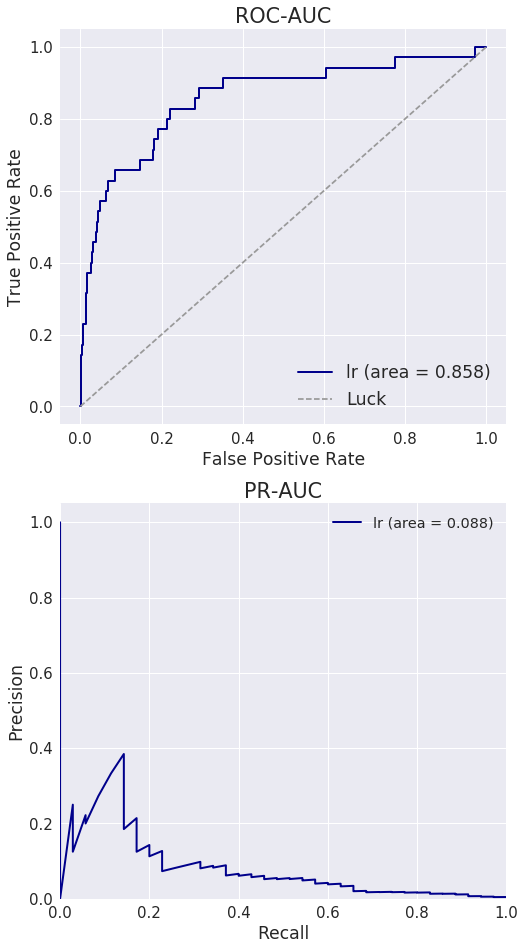

In [11]:
y_pred=clf_lr.fit(X_over_train[:,range(8)+[9,10,11,12]],y_over_train).predict_proba(X_dev[:,range(8)+[9,10,11,12]])[:,1]
draw_ROC_PRC_integrated2([(y_pred,y_dev,'lr')],'test',savefig=False)

Start!
lsvm


array([ 0.64257173])

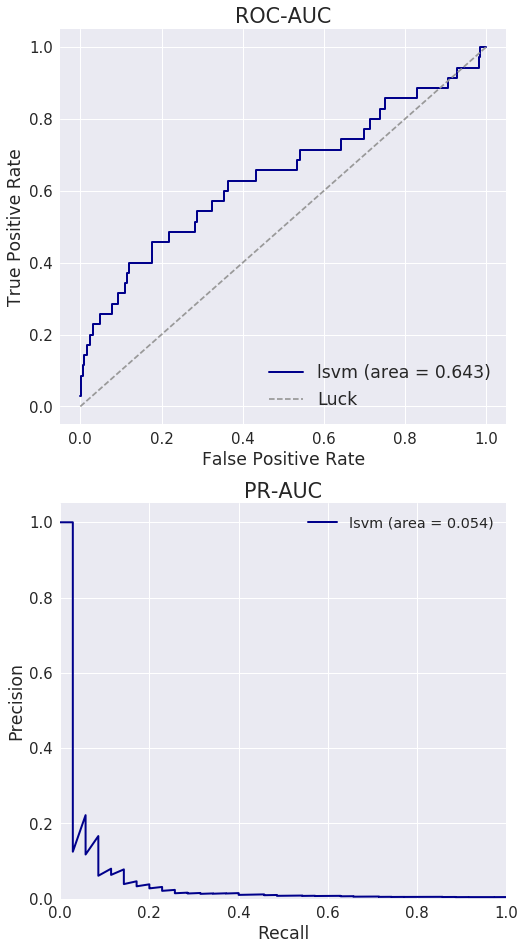

In [12]:
y_pred=clf_lsvm.fit(X_norm_over_train[:,range(8)+range(9,13)],y_over_train).decision_function(X_norm_dev[:,range(8)+range(9,13)])
draw_ROC_PRC_integrated2([(y_pred,y_dev,'lsvm')],'test',savefig=False)

## Predict with Test dataset

In [13]:
## Train with the whole training set, and do prediction on test dataset.
X_train=X
X_norm_train=X_norm
y_train=y

X_over_train=X_over
X_norm_over_train=X_norm_over
y_over_train=y_over

X_test=X_t
X_norm_test=X_norm_t

In [15]:
clf_lr_f=clf_lr.fit(X_over_train[:,range(8)+[9,10,11,12]],y_over_train)
y_pred_prob_lr=clf_lr_f.predict_proba(X_test[:,range(8)+[9,10,11,12]])[:,1]
y_pred_class_lr=clf_lr_f.predict(X_test[:,range(8)+[9,10,11,12]])

clf_lsvm_f=clf_lsvm.fit(X_norm_over_train[:,range(8)+range(9,13)],y_over_train)
y_pred_prob_lsvm=clf_lsvm_f.decision_function(X_norm_test[:,range(8)+range(9,13)])
y_pred_class_lsvm=clf_lsvm_f.predict(X_norm_test[:,range(8)+range(9,13)])

In [18]:
df=pd.DataFrame(zip(y_pred_prob_lr, y_pred_class_lr, y_pred_prob_lsvm, y_pred_class_lsvm), columns=['pred_prob_lr','pred_label_lr','pred_score_lsvm','pred_label_lsvm'])
df.to_csv('./ads_test_prediction.csv')
df

,pred_prob_lr,pred_label_lr,pred_score_lsvm,pred_label_lsvm
0,0.143692,0,-2201.963188,0
1,0.452566,0,-29.248714,0
2,0.300854,0,-334.523518,0
3,0.153068,0,-1057.601582,0
4,0.135025,0,-1928.186538,0
5,0.395744,0,-141.689236,0
6,0.225291,0,-568.221958,0
7,0.274491,0,-424.660797,0
8,0.138501,0,-2579.054171,0
9,0.203198,0,-770.098298,0
